<a href="https://colab.research.google.com/github/yellowlarva-sketch/aml-fraud-detection/blob/main/02_modeling_woe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

We aim to develop a predictive model that identifies potential money laundering cases by analyzing patterns in historical account transaction data.

Import Data from Kaggle Project
https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/code

In [58]:
# !pip install optbinning

In [29]:
# Connect drive to save data
from google.colab import drive
drive.mount('/content/drive')

# Set directory
main_dir = '/content/drive/My Drive/Colab Notebooks/'
input_dir = main_dir + '/00_inputs/'
script_dir = main_dir + '/01_scripts/'
output_dir = main_dir + '/02_outputs/'
model_ver = 'modelv1'
model_dir = output_dir + '{0}/'.format(model_ver)
non_predictive_cols = ['Is Laundering',  'X_fold','biz_dt']

# Import libraries
# %pip install 'cvxpy<1.5' ecos scs
import pandas as pd
import numpy as np
import math
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from optbinning import BinningProcess
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir(script_dir)

from utils import roc_curve_graph, mpr_report
from bmf import BinningModelFunction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import training dataset
Here we are predicting whether the account was involved in the laundering activity. Import data and check target label.


In [5]:
df = pd.read_csv(output_dir + 'modeling_data.csv')
print("Data shape:",df.shape)

predictive_cols = pd.read_csv(output_dir + 'predictive_columns.csv')
id_col = 'Account'
target = 'Is Laundering'
features = list(predictive_cols['0'])
print("Number of features:",len(features))

df[target].value_counts(normalize=False)

Data shape: (1550716, 45)
Number of features: 41


,count
Is Laundering,
0,1546751
1,3965


Split the train and test and out of time validation set.

In [6]:
# This will be used for cross-validation hyperparameter tuning
X_train = df[df['X_fold'].isin(['train', 'valid'])][features].head(10000)
y_train = df[df['X_fold'].isin(['train', 'valid'])][target].head(10000)

# This will be used for model algorithm comparison & setting optimal threshold
X_test = df[df['X_fold'] == 'test'][features]
y_test = df[df['X_fold'] == 'test'][target]

# This will be used for model algorithm comparison & setting optimal threshold
X_oot = df[df['X_fold'] == 'outoftime'][features]
y_oot = df[df['X_fold'] == 'outoftime'][target]

Define model parameter search space

In [17]:
search_space = {
    'min_n_bins': hp.choice('min_n_bins', [4, 5, 6]),
    'max_n_bins': hp.choice('max_n_bins', [10, 15, 20]),
    'min_iv': hp.choice('min_iv', [0.1]),
    'binned_metric': hp.choice('binned_metric', ['woe']),
    'monotonic_trend': hp.choice('monotonic_trend', ['auto']), #, 'ascending', 'descending'
    'num_features': hp.choice('num_features', ['all']), #10, 20, 30

    # Model params
    'C': hp.loguniform('C', np.log(0.01), np.log(10)),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'n_estimators': hp.choice('n_estimators', [100, 200]),
    'max_depth': hp.choice('max_depth', [5, 10, None]),

}


In [18]:
special_codes = [0]
bmf = BinningModelFunction(X_train, y_train, features, special_codes, search_space, model_dir)

# Hyperparameter tuning

In [19]:
bmf.run_model('lr', 3)

100%|██████████| 3/3 [00:04<00:00,  1.66s/trial, best loss: -0.90671522870302]


In [21]:
bmf.run_model('rf', 3)

100%|██████████| 3/3 [00:17<00:00,  5.88s/trial, best loss: -0.8358723888880519]


In [22]:
bmf.run_model('lgbm', 3)

100%|██████████| 3/3 [00:07<00:00,  2.42s/trial, best loss: -0.8715334415698566]


In [23]:
bmf.run_model('xgb', 3)

100%|██████████| 3/3 [00:03<00:00,  1.00s/trial, best loss: -0.8939713562463272]


In [24]:
bmf.run_model('gbm', 3)

100%|██████████| 3/3 [00:16<00:00,  5.44s/trial, best loss: -0.8591059186041254]


Best loss: -0.9067
Best parameters: {'C': 5.53601212817943, 'binned_metric': 'woe', 'l1_ratio': 0.5717431237114835, 'm_method': 'lr', 'max_depth': 5, 'max_n_bins': 10, 'min_iv': 0.1, 'min_n_bins': 4, 'monotonic_trend': 'auto', 'n_estimators': 100, 'num_features': 'all', 'penalty': 'l1'}


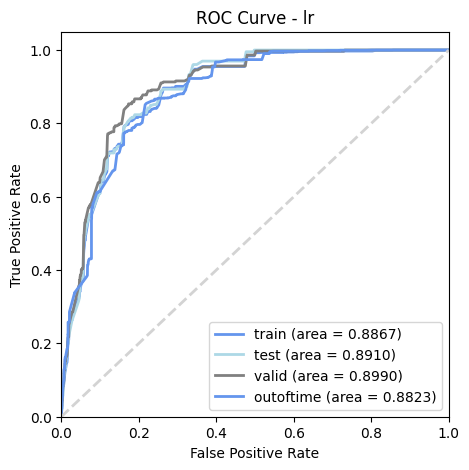

<Figure size 640x480 with 0 Axes>

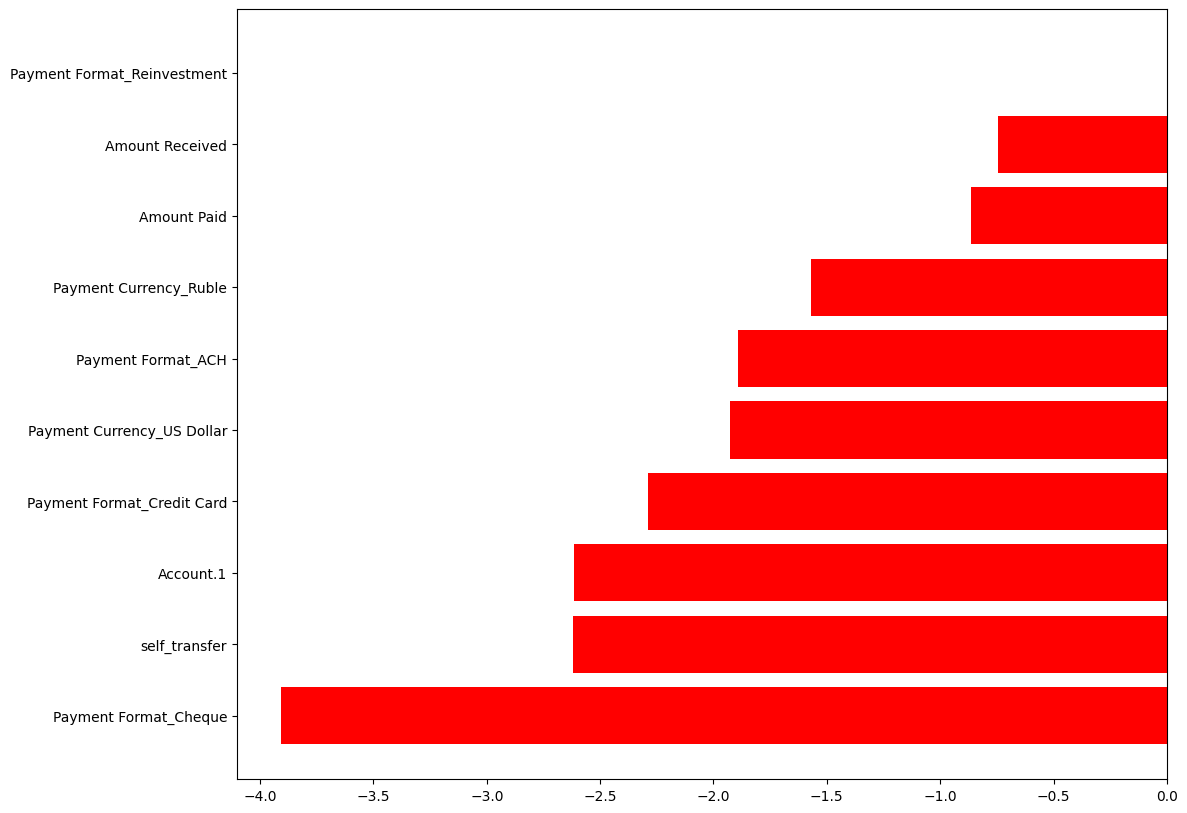

Best loss: -0.8359
Best parameters: {'C': 0.3597234898891214, 'binned_metric': 'woe', 'l1_ratio': 0.44384409789611967, 'm_method': 'rf', 'max_depth': 5, 'max_n_bins': 10, 'min_iv': 0.1, 'min_n_bins': 5, 'monotonic_trend': 'auto', 'n_estimators': 200, 'num_features': 'all', 'penalty': 'l2'}


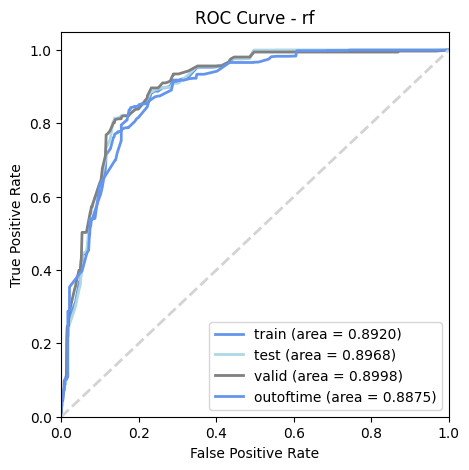

<Figure size 640x480 with 0 Axes>

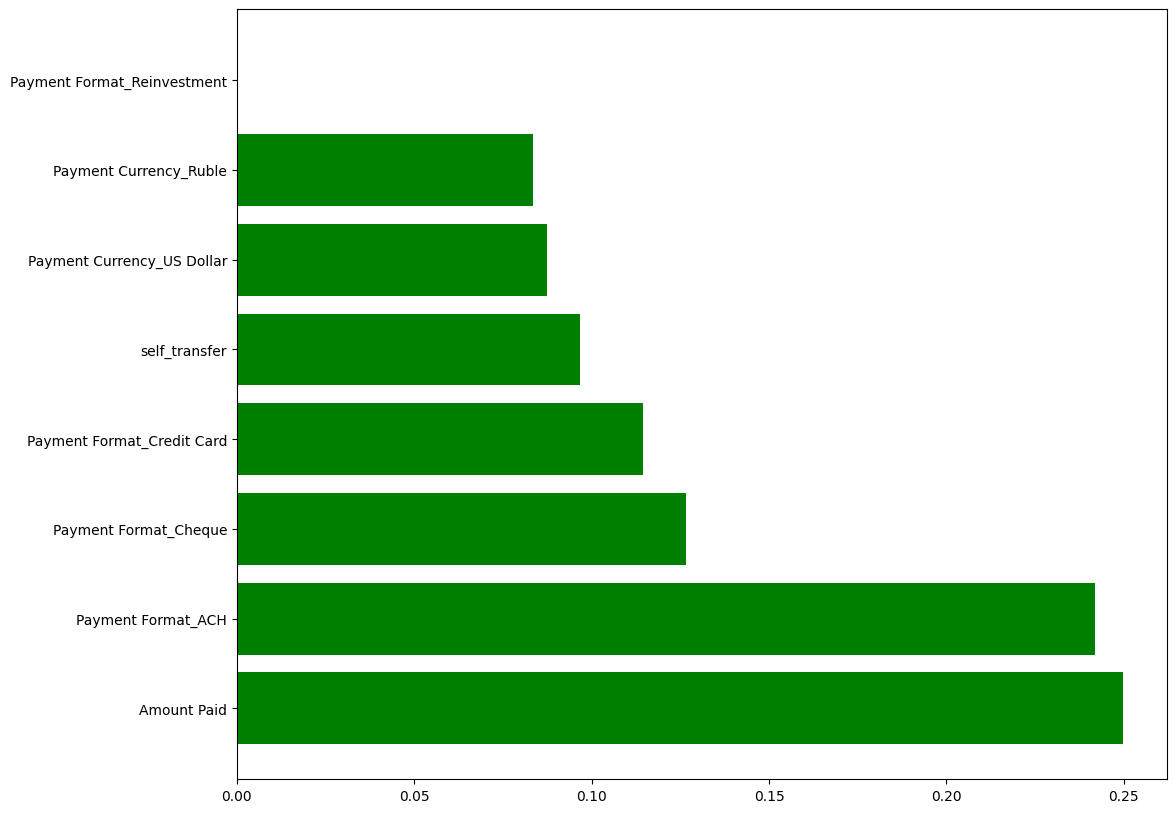

Best loss: -0.8715
Best parameters: {'C': 0.28364736278300107, 'binned_metric': 'woe', 'l1_ratio': 0.24094672799298988, 'm_method': 'lgbm', 'max_depth': None, 'max_n_bins': 20, 'min_iv': 0.1, 'min_n_bins': 4, 'monotonic_trend': 'auto', 'n_estimators': 100, 'num_features': 'all', 'penalty': 'l2'}


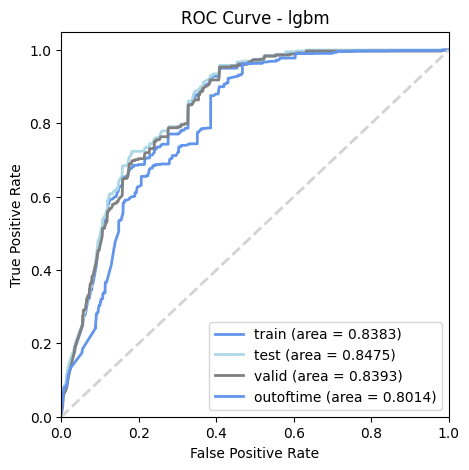

<Figure size 640x480 with 0 Axes>

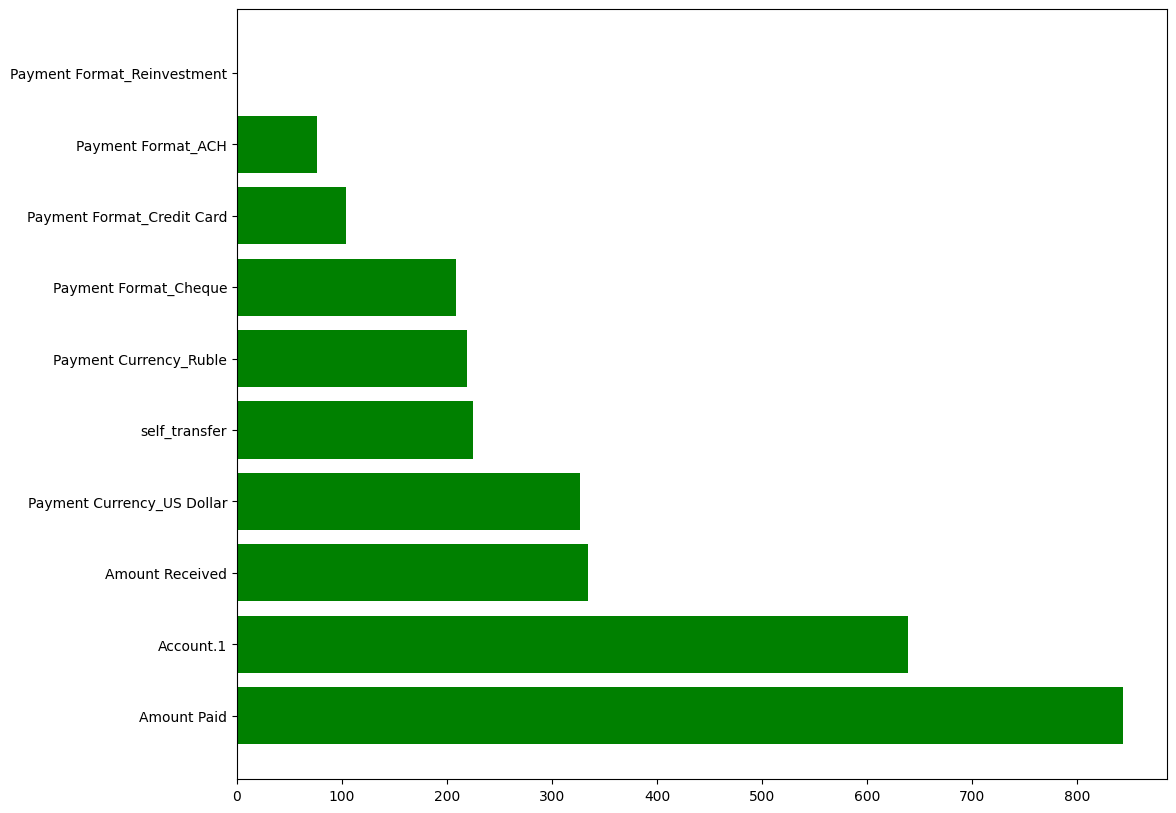

Best loss: -0.8940
Best parameters: {'C': 0.39952541654315527, 'binned_metric': 'woe', 'l1_ratio': 0.6454240989759322, 'm_method': 'xgb', 'max_depth': 10, 'max_n_bins': 20, 'min_iv': 0.1, 'min_n_bins': 4, 'monotonic_trend': 'auto', 'n_estimators': 100, 'num_features': 'all', 'penalty': 'l2'}


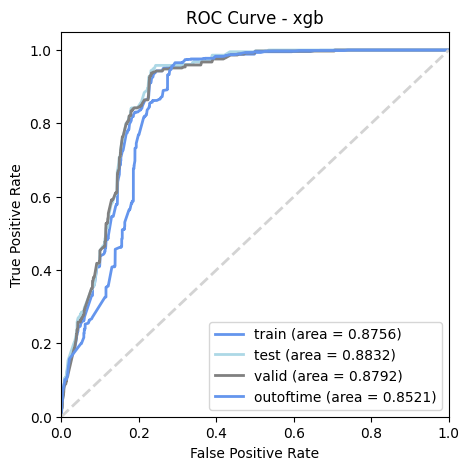

<Figure size 640x480 with 0 Axes>

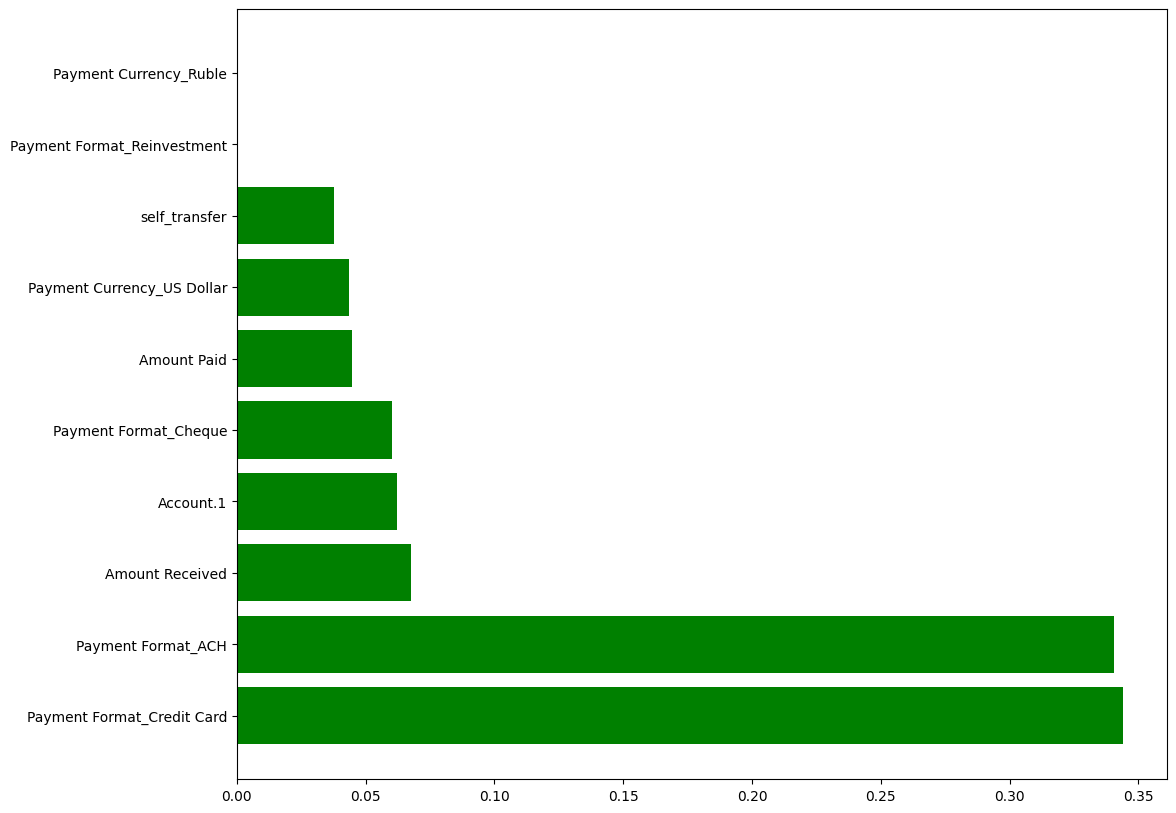

Best loss: -0.8591
Best parameters: {'C': 1.433457061520912, 'binned_metric': 'woe', 'l1_ratio': 0.582381587532346, 'm_method': 'gbm', 'max_depth': 5, 'max_n_bins': 20, 'min_iv': 0.1, 'min_n_bins': 6, 'monotonic_trend': 'auto', 'n_estimators': 100, 'num_features': 'all', 'penalty': 'l2'}


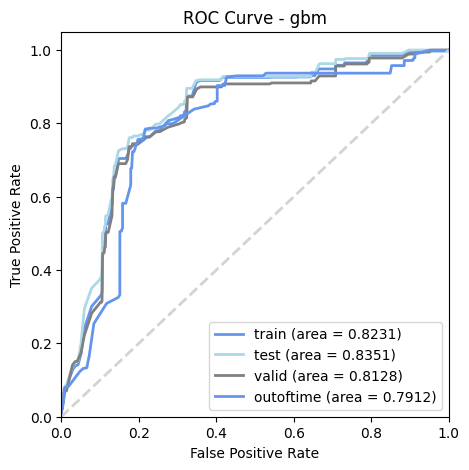

<Figure size 640x480 with 0 Axes>

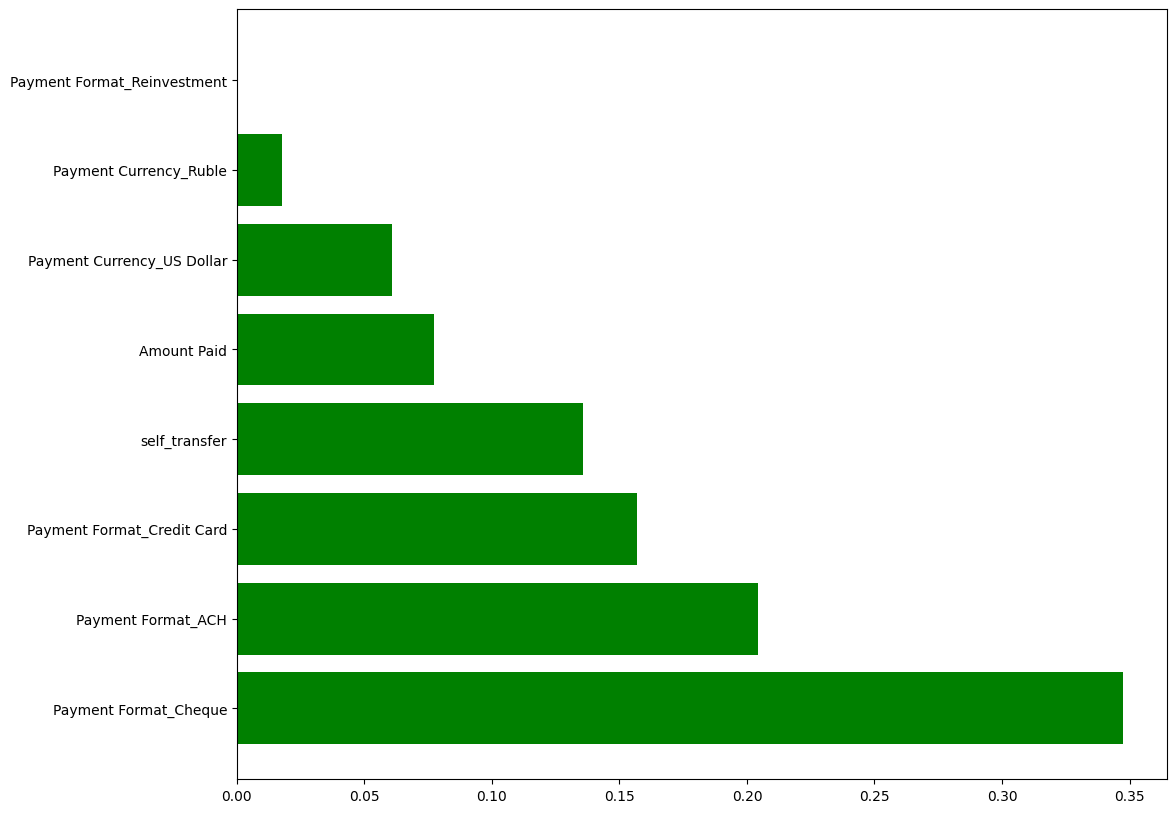

In [27]:
model_list = ['lr', 'rf', 'lgbm', 'xgb', 'gbm']
score_df = bmf.final_fitting_overall(model_list, df, 'woe', target, id_col, non_predictive_cols, roc_curve_graph)

# Review model performance

In [50]:
sample_list = [['test'], ['outoftime'], ['test', 'outoftime']]
threshold_list = [0.01 * i for i in range(10) if i > 0]
mpr = mpr_report(model_list, sample_list, threshold_list, score_df, target)
mpr

,Model_name,Accuracy,Precision,Recall,F1_score,AUROC,TN,FP,FN,TP,Total,Threshold,sample
0,lr,0.944506,0.012906,0.378190,0.024960,0.661881,216588,12467,268,163,229486,0.01,['test']
0,lr,0.981955,0.022154,0.199536,0.039879,0.591482,225259,3796,345,86,229486,0.02,['test']
0,lr,0.990975,0.027650,0.111369,0.044301,0.552000,227367,1688,383,48,229486,0.03,['test']
0,lr,0.991677,0.025048,0.090487,0.039235,0.541930,227537,1518,392,39,229486,0.04,['test']
0,lr,0.993790,0.023946,0.058005,0.033898,0.526778,228036,1019,406,25,229486,0.05,['test']
0,lr,0.995577,0.027508,0.039443,0.032412,0.518410,228454,601,414,17,229486,0.06,['test']
0,lr,0.995947,0.030132,0.037123,0.033264,0.517437,228540,515,415,16,229486,0.07,['test']
0,lr,0.996174,0.021413,0.023202,0.022272,0.510603,228598,457,421,10,229486,0.08,['test']
0,lr,0.996505,0.025575,0.023202,0.024331,0.510769,228674,381,421,10,229486,0.09,['test']
0,lr,0.921773,0.022702,0.430648,0.043130,0.677220,371031,30608,940,711,403290,0.01,['outoftime']


In [53]:
bmf.feature_consolidation(model_list, 'woe')

,features,Imp_lr,Imp_rf,Imp_lgbm,Imp_xgb,Imp_gbm
0,Account.1,0.669478,NaN,0.758007,0.180707,NaN
1,Amount Paid,0.221310,1.000000,1.000000,0.129730,0.223037
2,Amount Received,0.190680,NaN,0.396204,0.196739,NaN
3,Payment Currency_Australian Dollar,NaN,NaN,NaN,NaN,NaN
4,Payment Currency_Bitcoin,NaN,NaN,NaN,NaN,NaN
5,Payment Currency_Brazil Real,NaN,NaN,NaN,NaN,NaN
6,Payment Currency_Canadian Dollar,NaN,NaN,NaN,NaN,NaN
7,Payment Currency_Euro,NaN,NaN,NaN,NaN,NaN
8,Payment Currency_Mexican Peso,NaN,NaN,NaN,NaN,NaN
9,Payment Currency_Ruble,0.402041,0.334295,0.259786,0.000000,0.050916


# Binned Features

lr -- Amount Received


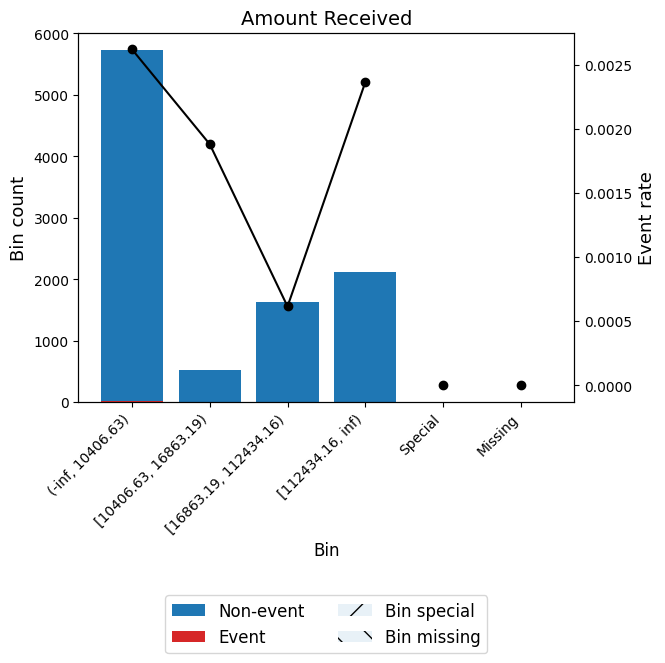

lr -- Amount Paid


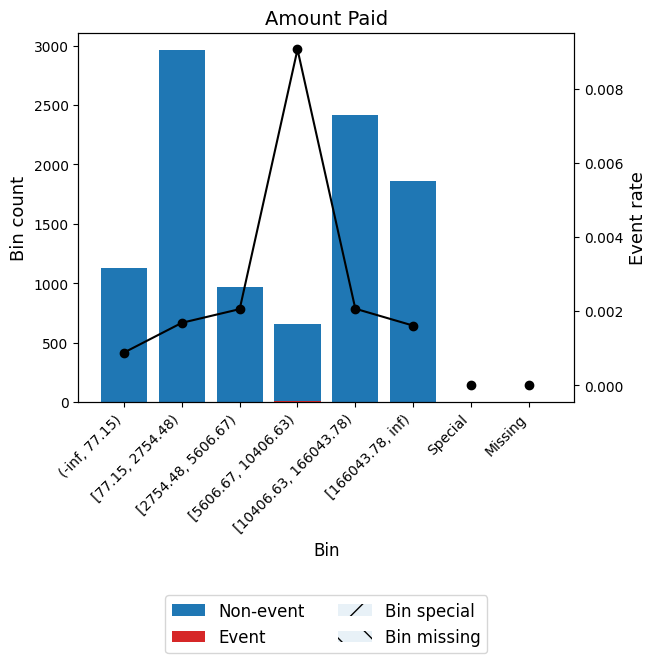

lr -- Payment Format_ACH


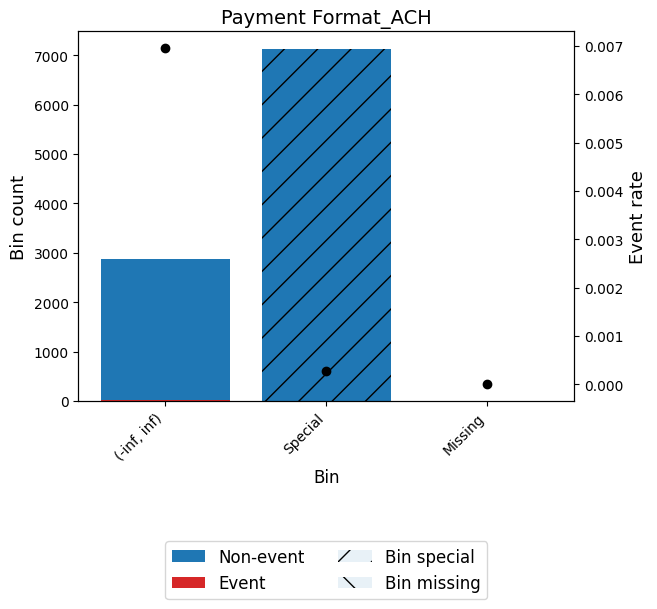

lr -- Payment Format_Cheque


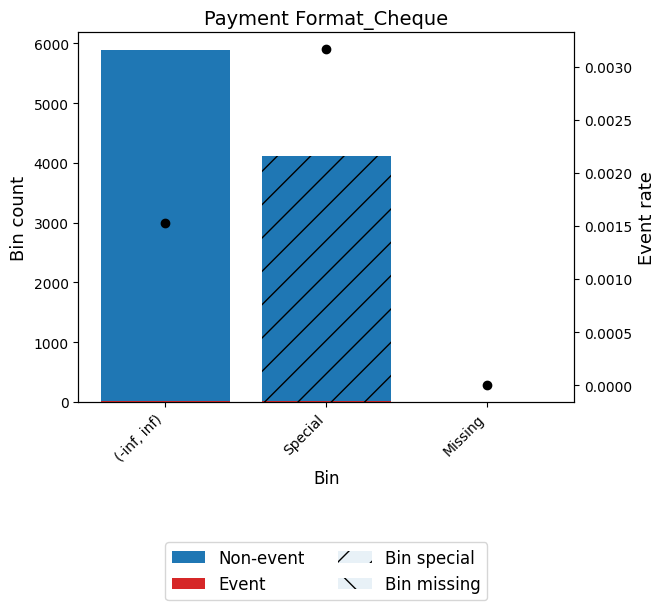

lr -- Payment Format_Credit Card


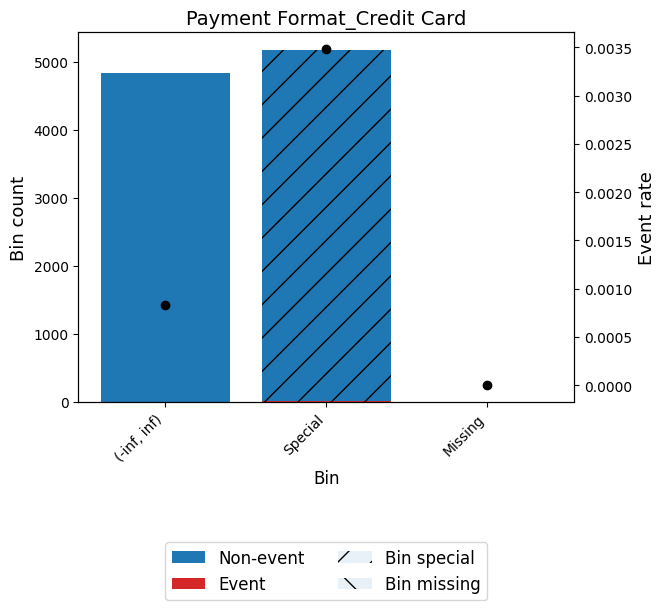

lr -- Payment Format_Reinvestment


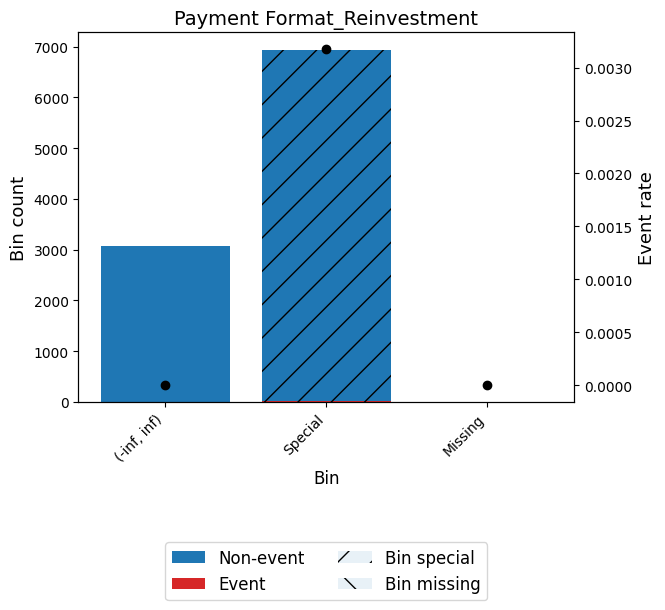

lr -- Payment Currency_Ruble


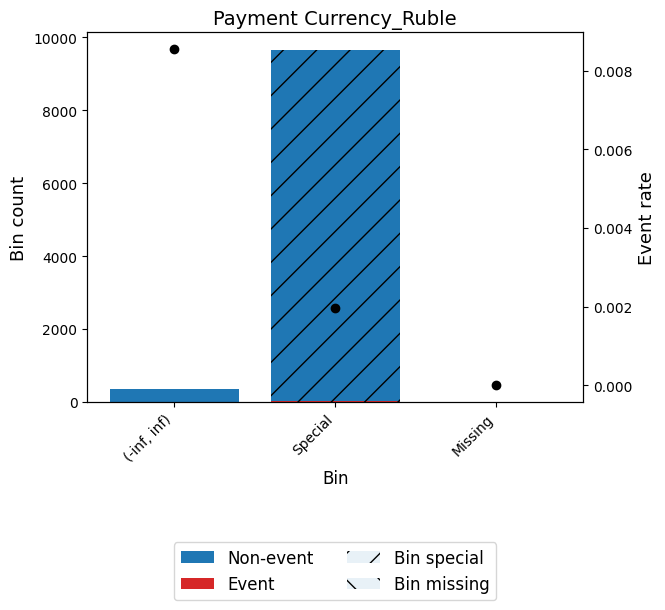

lr -- Payment Currency_US Dollar


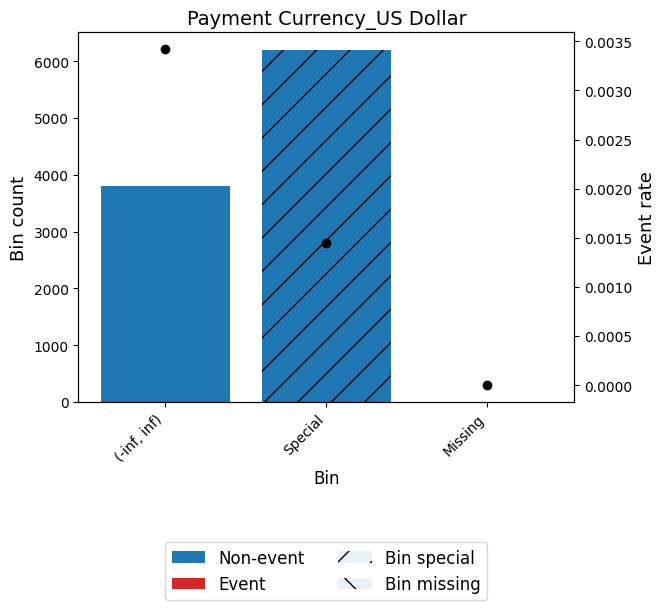

lr -- self_transfer


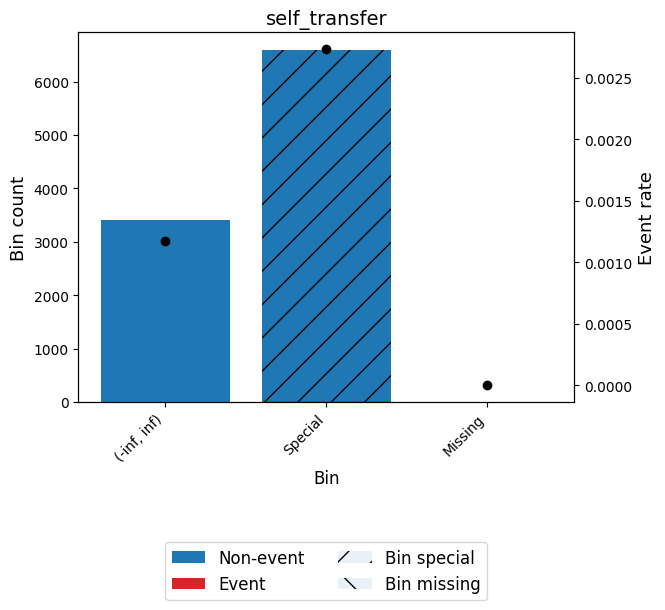

lr -- Account.1


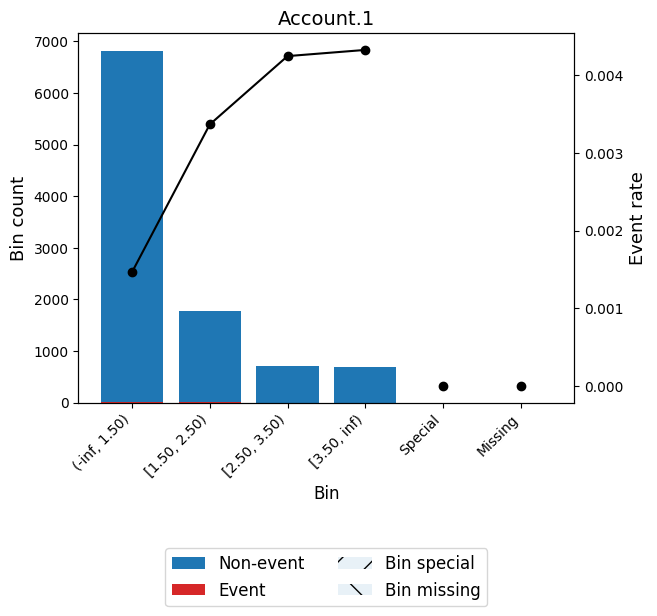

rf -- Amount Paid


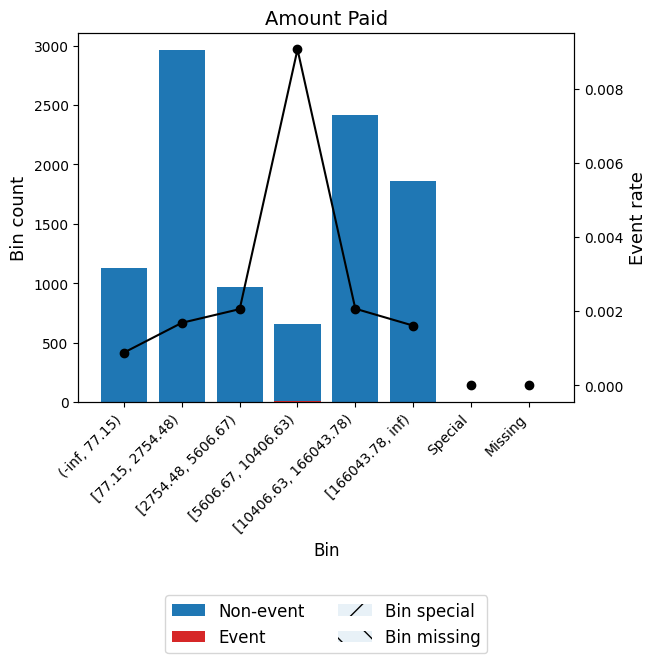

rf -- Payment Format_ACH


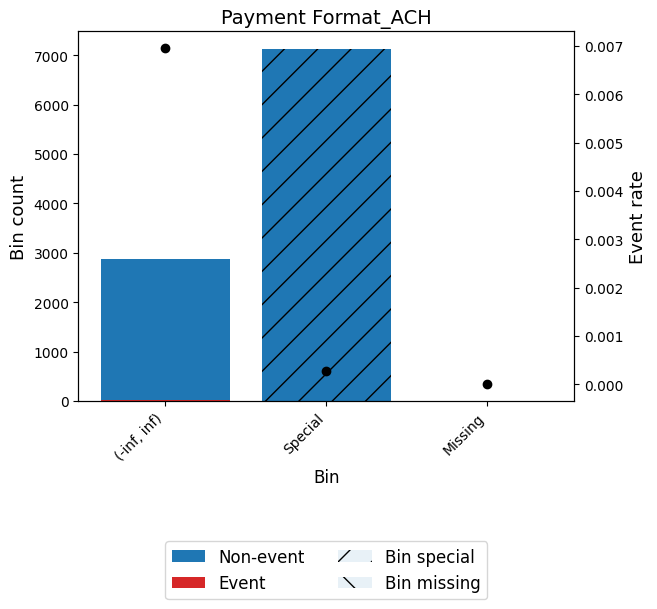

rf -- Payment Format_Cheque


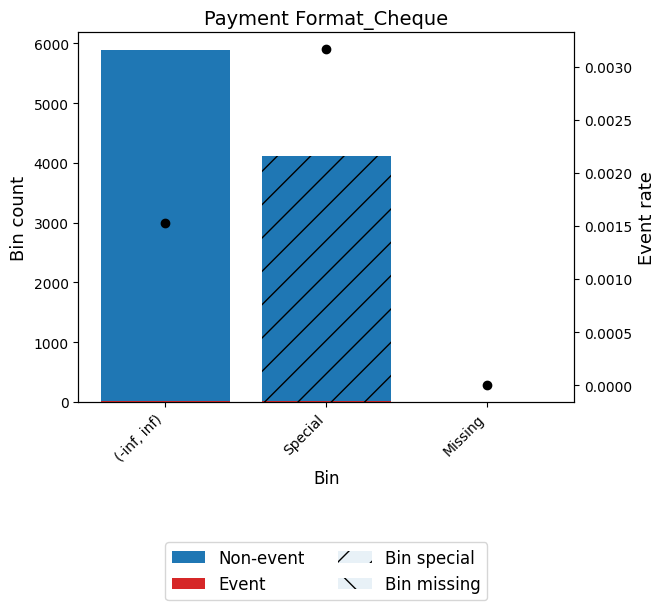

rf -- Payment Format_Credit Card


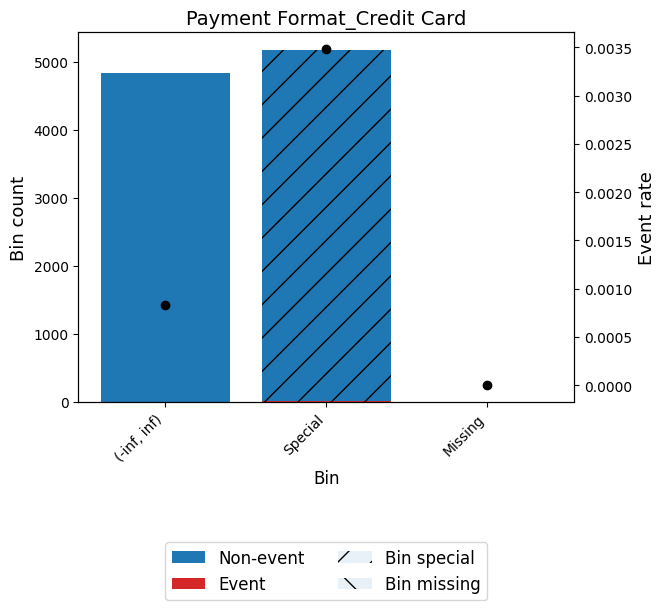

rf -- Payment Format_Reinvestment


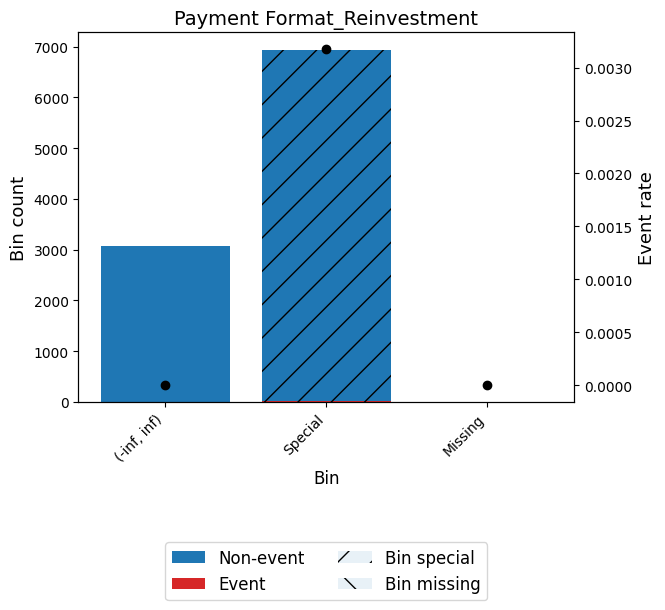

rf -- Payment Currency_Ruble


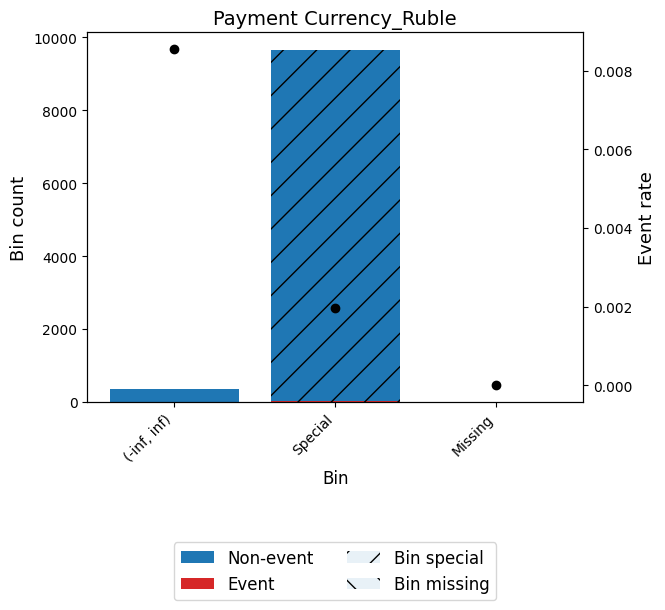

rf -- Payment Currency_US Dollar


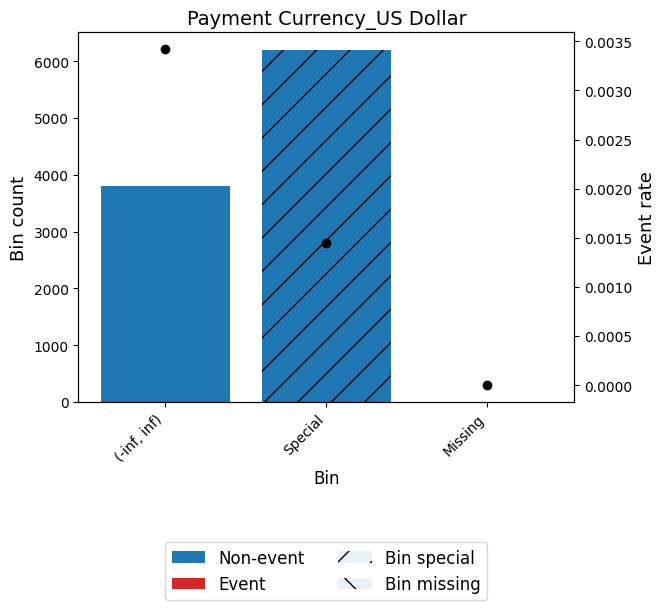

rf -- self_transfer


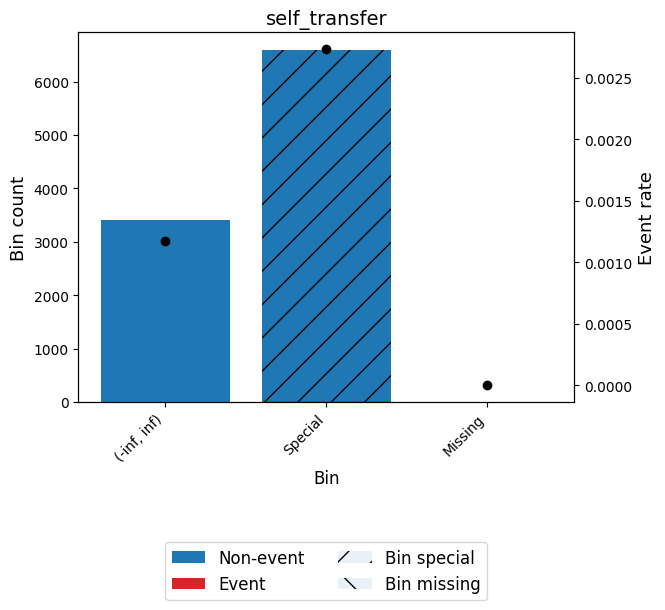

lgbm -- Amount Received


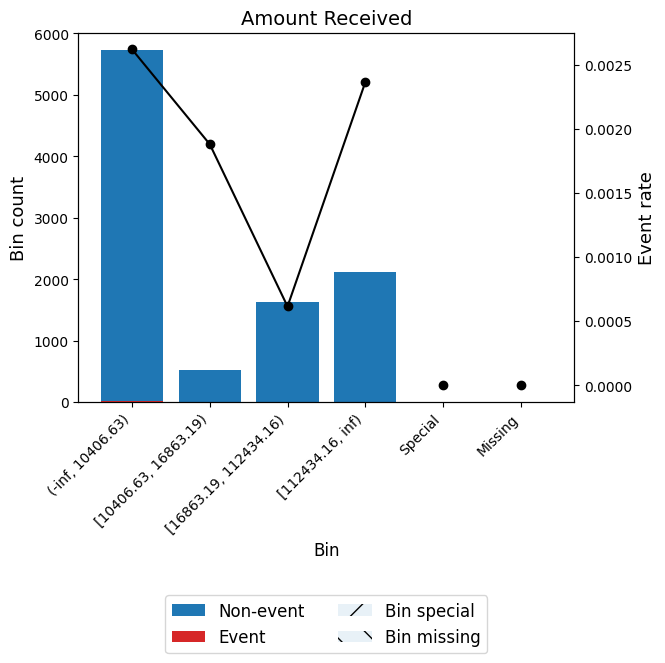

lgbm -- Amount Paid


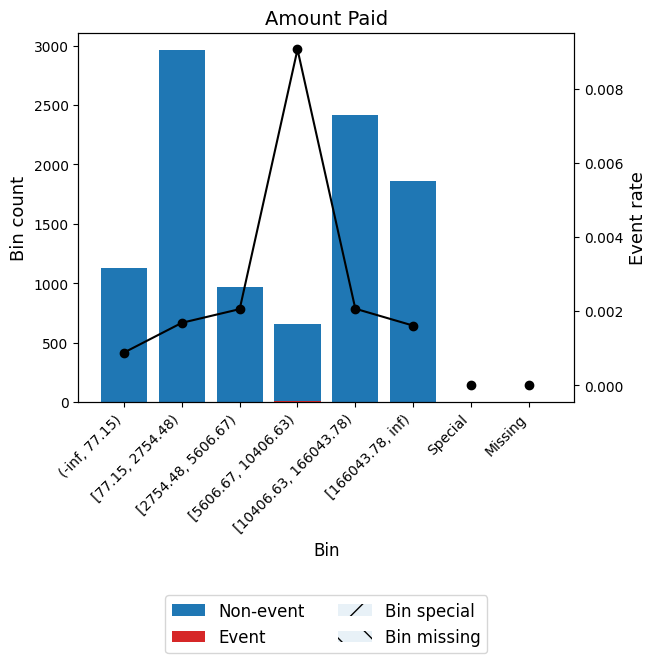

lgbm -- Payment Format_ACH


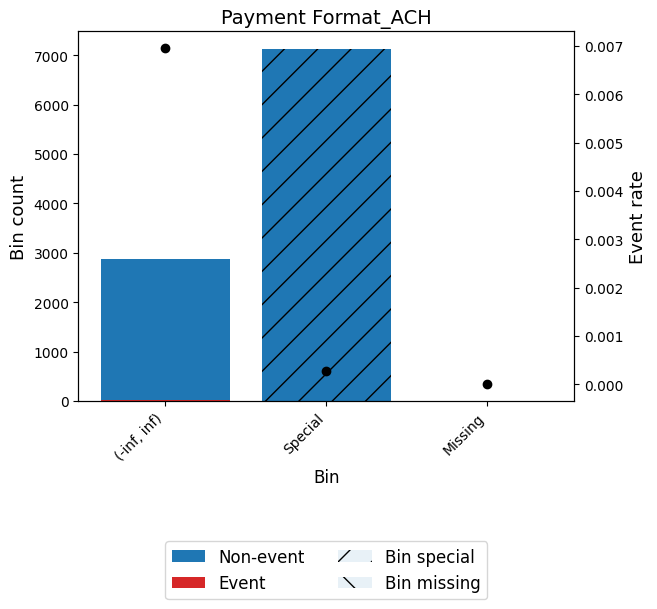

lgbm -- Payment Format_Cheque


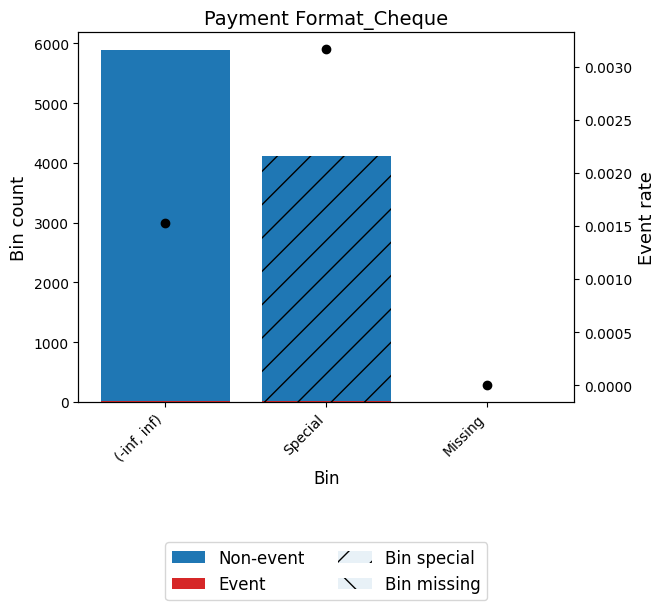

lgbm -- Payment Format_Credit Card


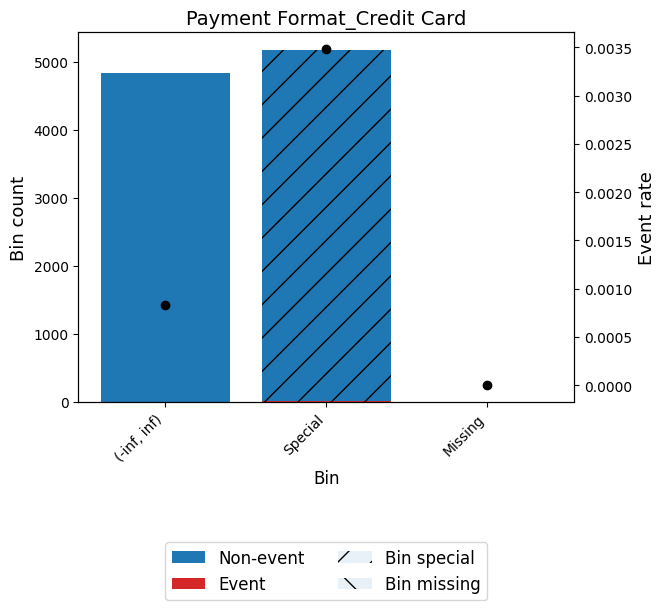

lgbm -- Payment Format_Reinvestment


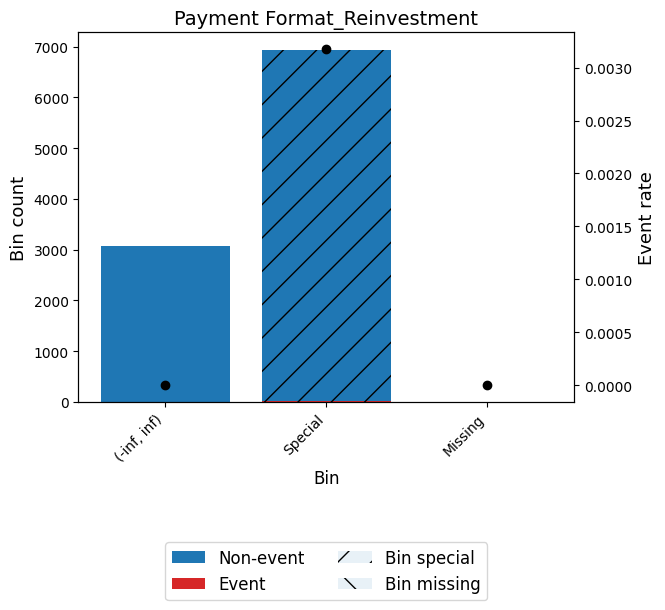

lgbm -- Payment Currency_Ruble


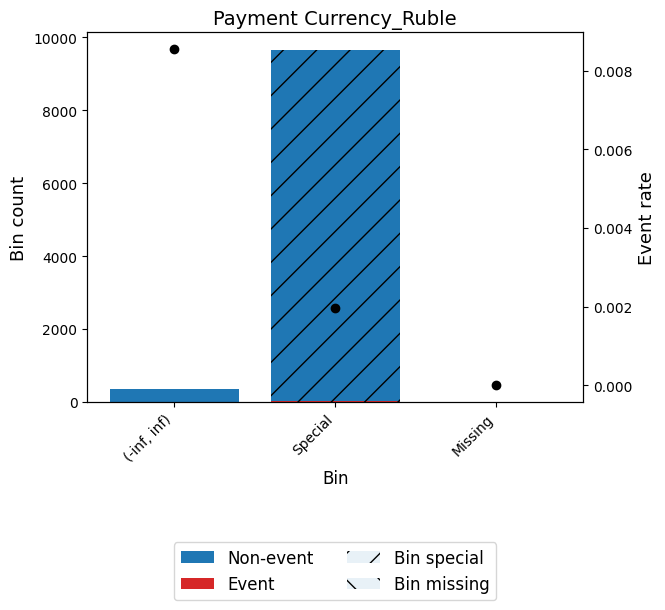

lgbm -- Payment Currency_US Dollar


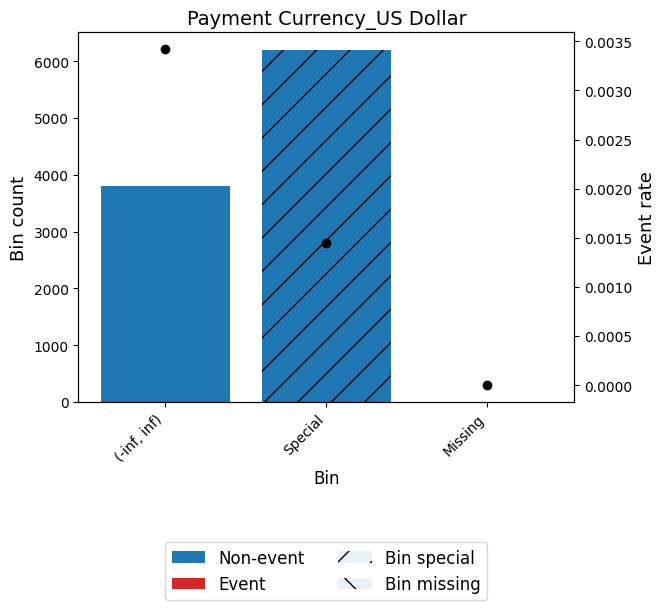

lgbm -- self_transfer


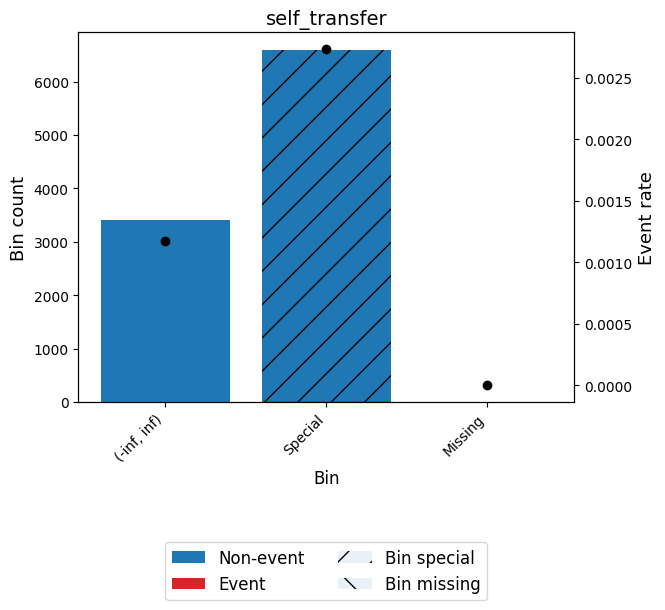

lgbm -- Account.1


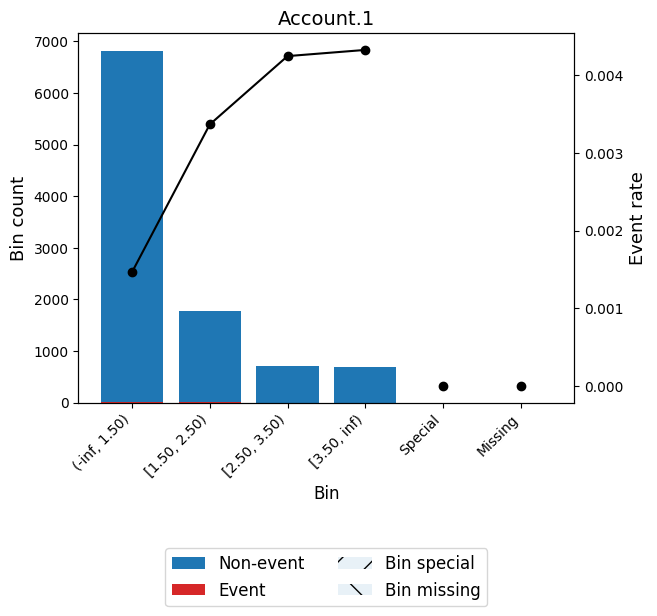

xgb -- Amount Received


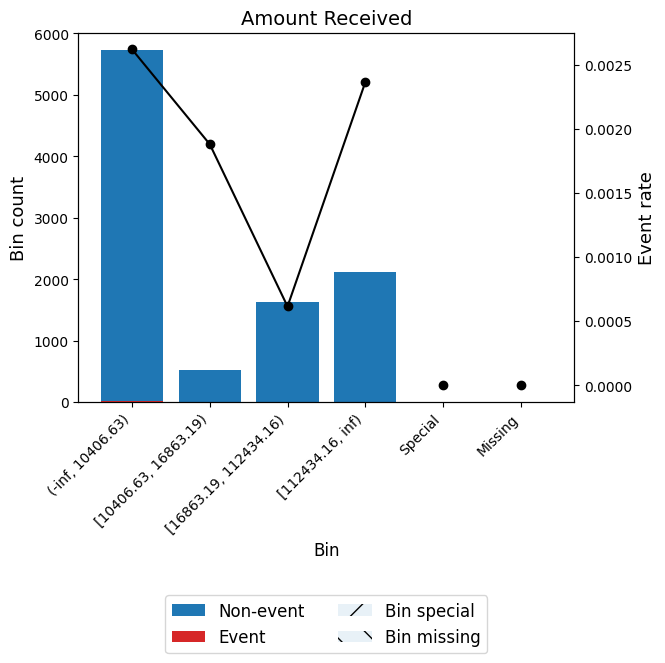

xgb -- Amount Paid


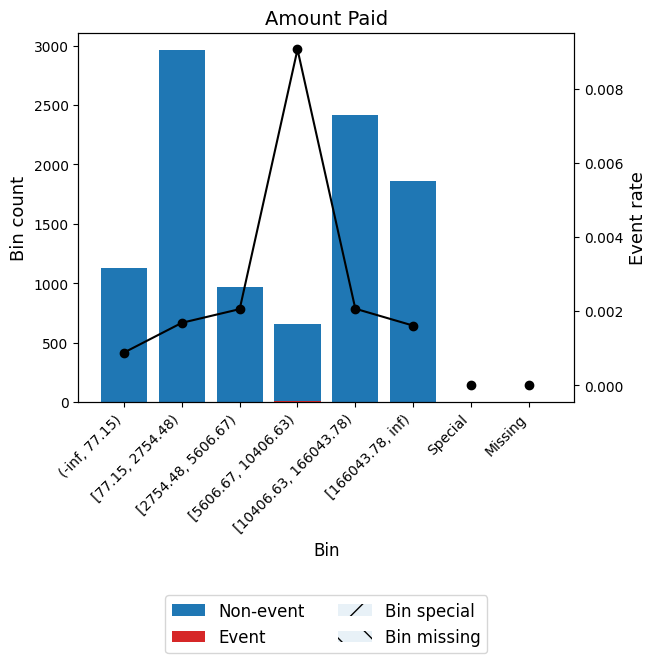

xgb -- Payment Format_ACH


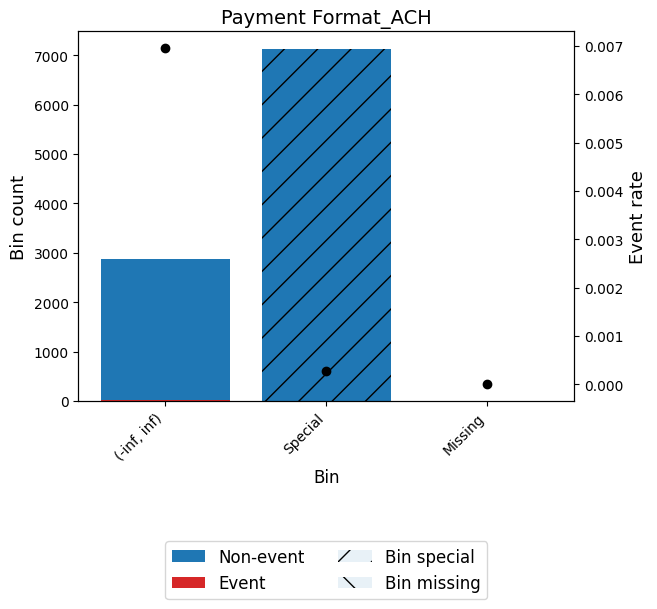

xgb -- Payment Format_Cheque


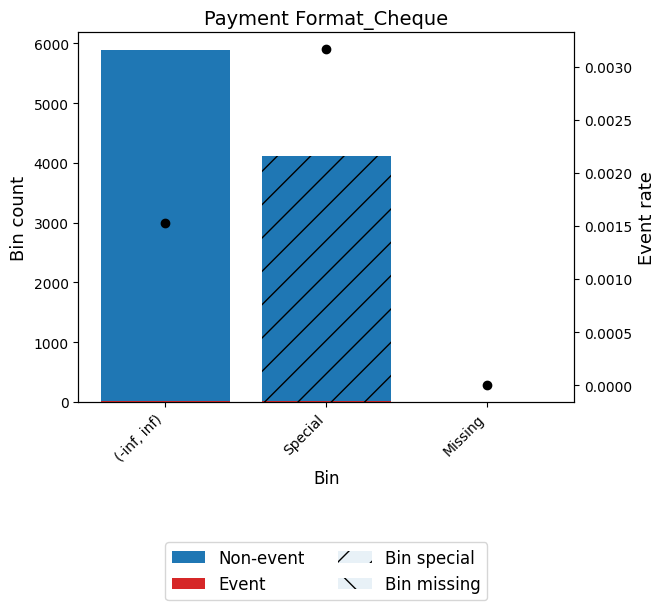

xgb -- Payment Format_Credit Card


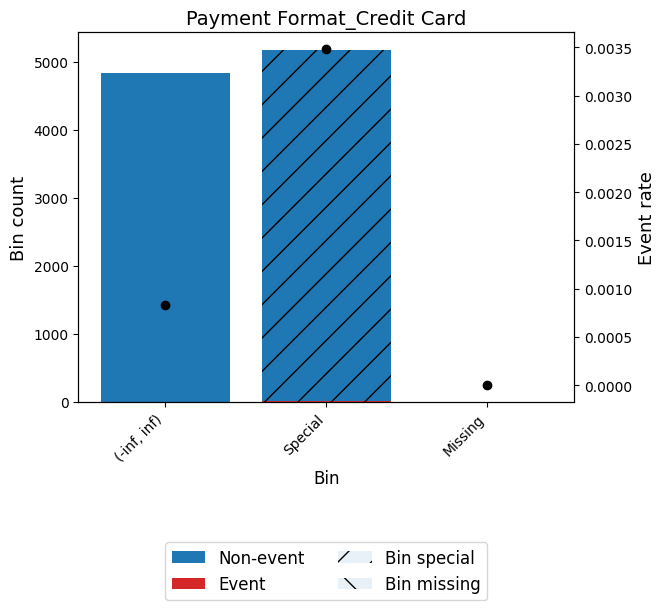

xgb -- Payment Format_Reinvestment


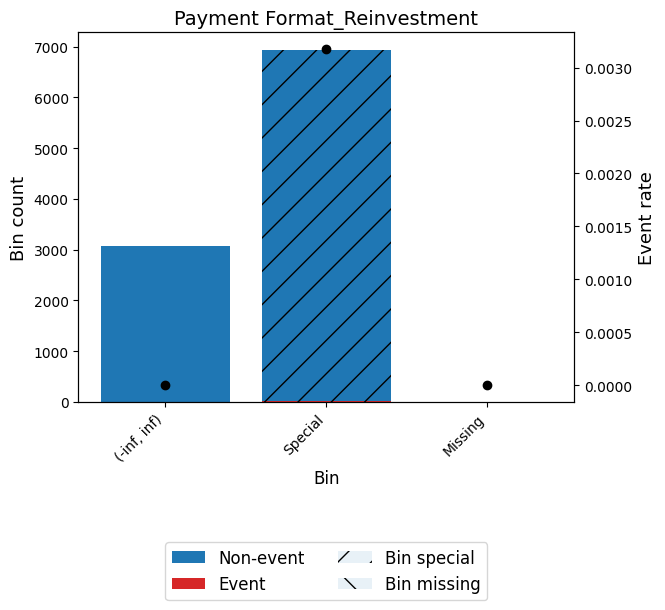

xgb -- Payment Currency_Ruble


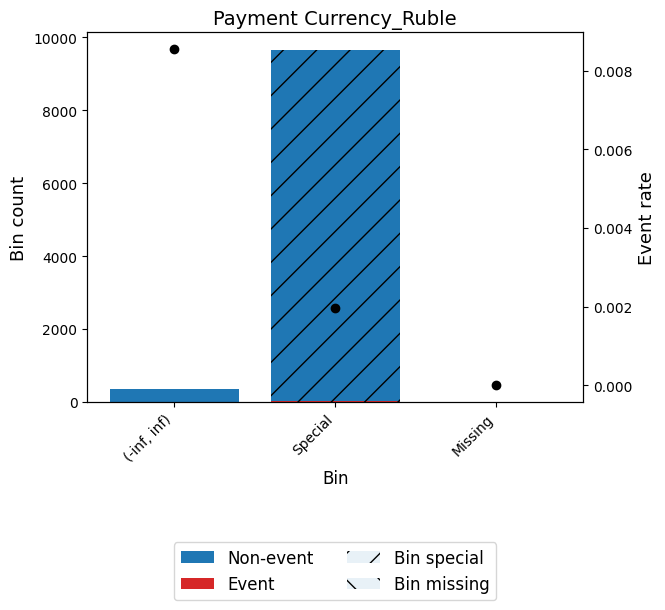

xgb -- Payment Currency_US Dollar


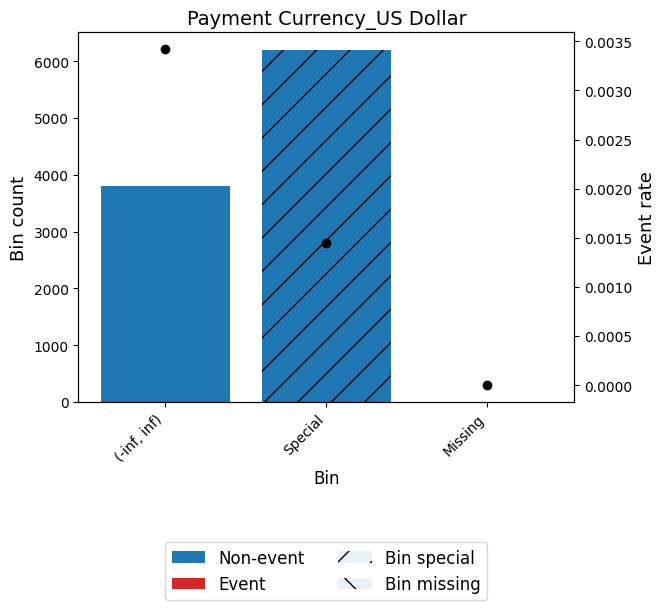

xgb -- self_transfer


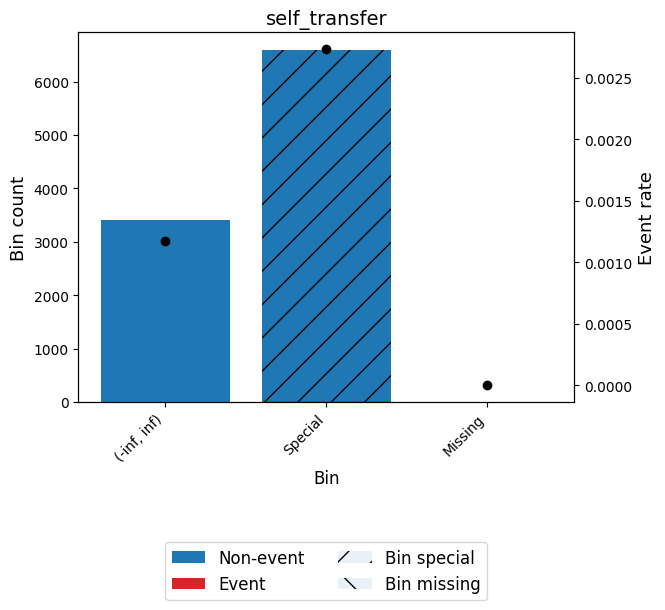

xgb -- Account.1


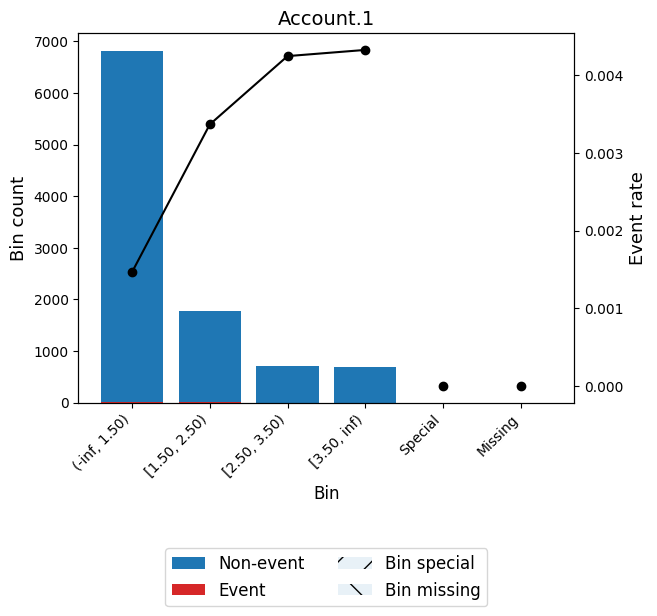

gbm -- Amount Paid


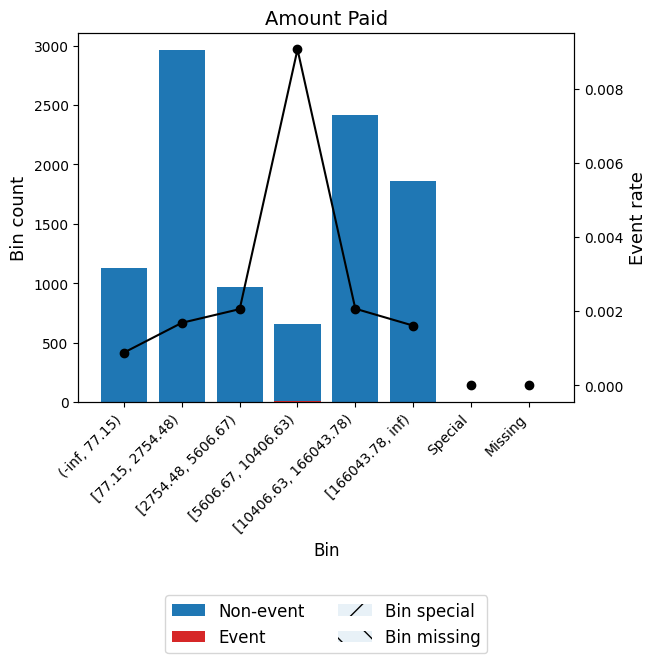

gbm -- Payment Format_ACH


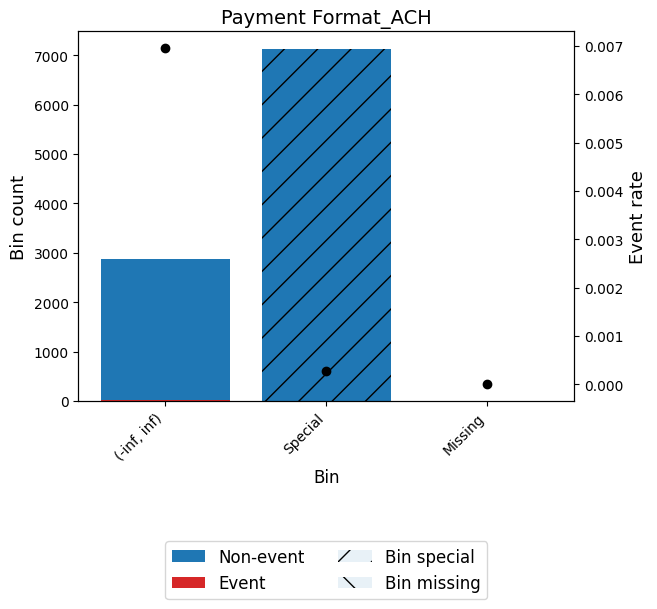

gbm -- Payment Format_Cheque


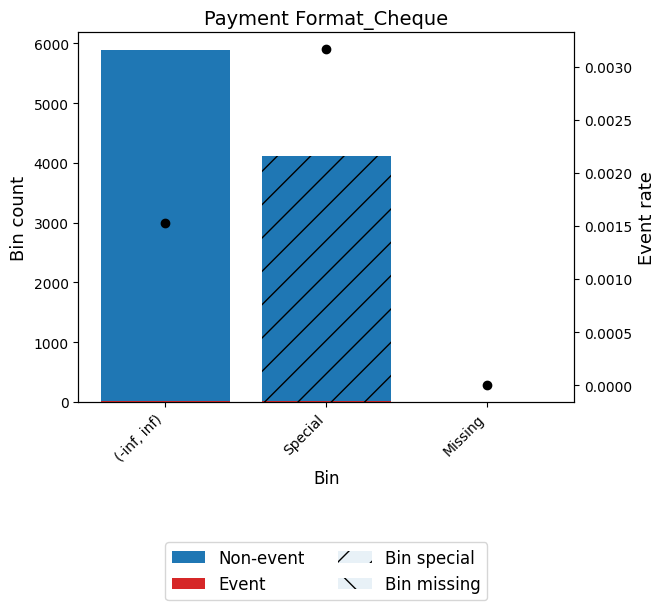

gbm -- Payment Format_Credit Card


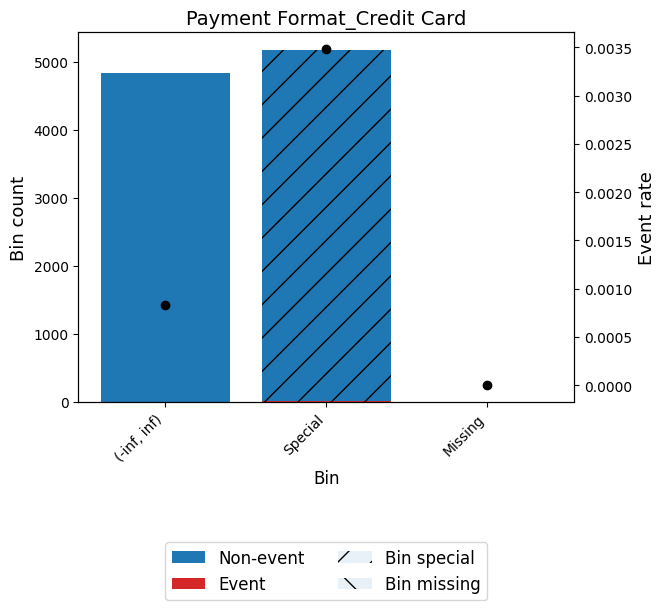

gbm -- Payment Format_Reinvestment


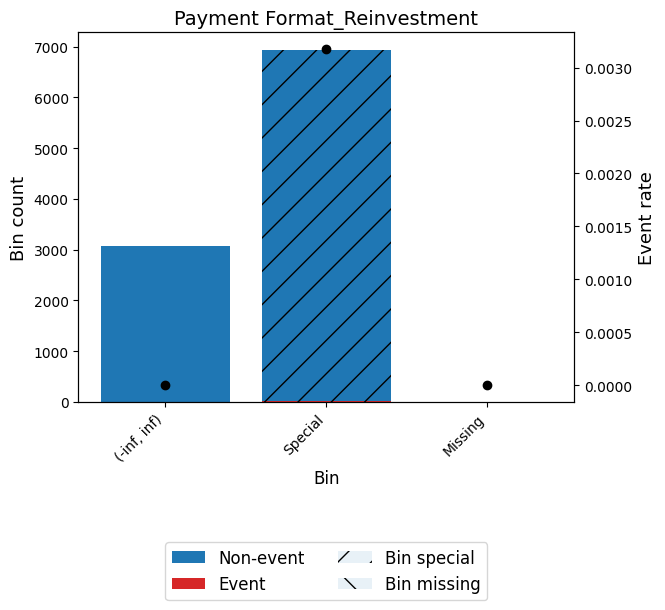

gbm -- Payment Currency_Ruble


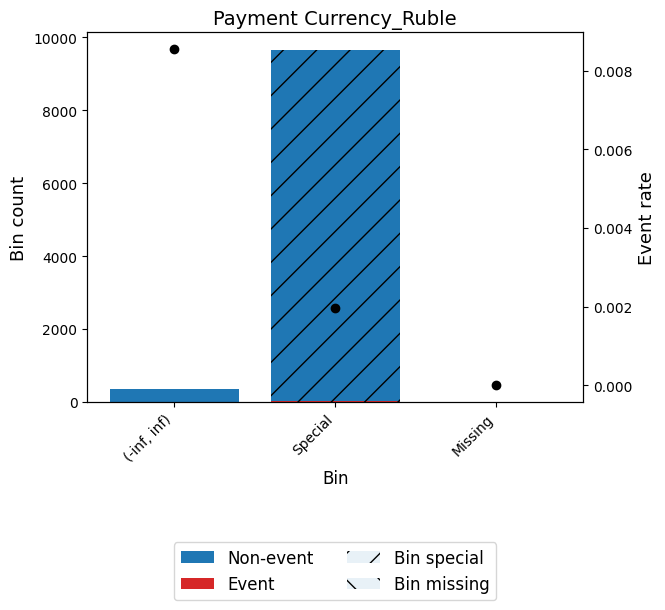

gbm -- Payment Currency_US Dollar


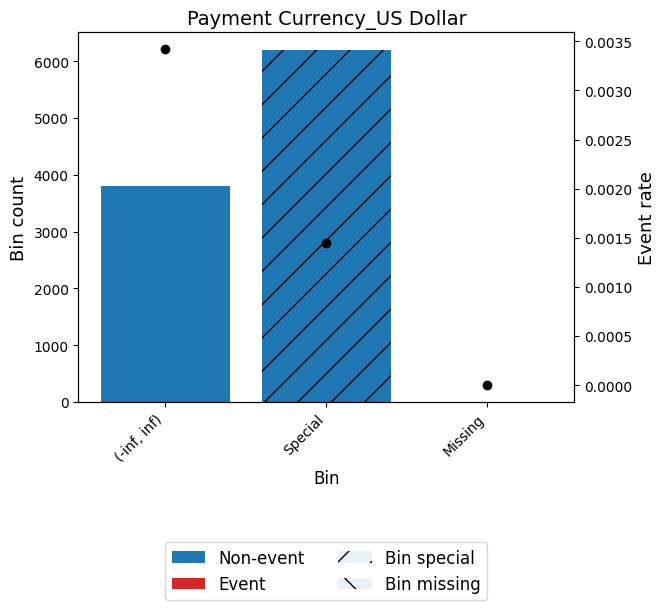

gbm -- self_transfer


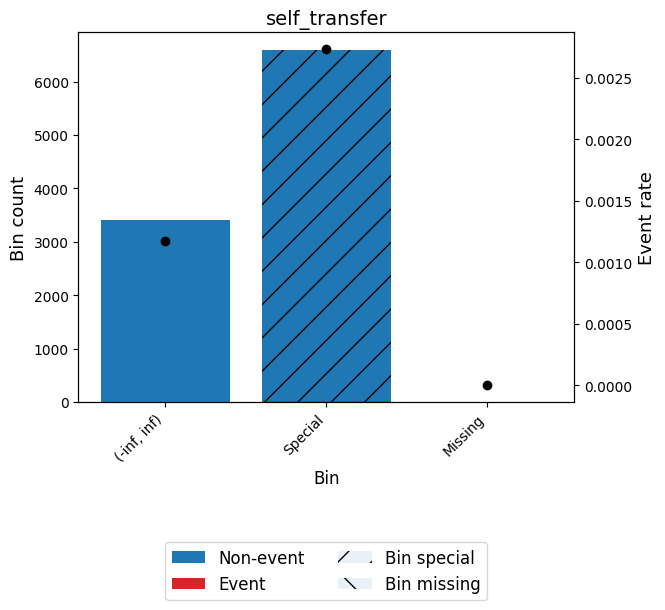

In [56]:
bin_table = pd.DataFrame()
for m_method in model_list:
  bp = pickle.load(open(f"{model_dir}/{m_method}/{m_method}_binning.pkl", 'rb'))
  final_features = pd.read_csv(f"{model_dir}/{m_method}/{m_method}_features.csv")['0'].tolist()

  for i in final_features:
    print(m_method,'--', i)
    # Get the binned variable
    binned_var = bp.get_binned_variable(i)

    # Build and plot the binning table
    binning_table = binned_var.binning_table.build()
    binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
    tmp = binned_var.binning_table.build()
    tmp['model'] = m_method
    bin_table = pd.concat([bin_table, tmp])

In [57]:
bin_table

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,model
0,"(-inf, 10406.63)",5727,0.5727,5712,15,0.002619,-0.174821,0.019118,0.002387,lr
1,"[10406.63, 16863.19)",532,0.0532,531,1,0.001880,0.157667,0.001224,0.000153,lr
2,"[16863.19, 112434.16)",1625,0.1625,1624,1,0.000615,1.275552,0.149627,0.017530,lr
3,"[112434.16, inf)",2116,0.2116,2111,5,0.002363,-0.071616,0.001125,0.000141,lr
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000,lr
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000,lr
Totals,,10000,1.0000,9978,22,0.002200,,0.171094,0.020210,lr
0,"(-inf, 77.15)",1128,0.1128,1127,1,0.000887,0.910219,0.061434,0.007425,lr
1,"[77.15, 2754.48)",2961,0.2961,2956,5,0.001689,0.265059,0.018284,0.002279,lr
2,"[2754.48, 5606.67)",972,0.0972,970,2,0.002058,0.067053,0.000423,0.000053,lr


END